# Grover amplification

This notebook shows how to use Alice & Bob emulators to solve a simple SAT problem using Grover's algorithm.
The algorithm is run on an abstract quantum processor made of logical qubits. 

A logical qubit is the combination of multiple physical cat qubits into a more robust qubit using a linear repetition error correction code.
The emulator of logical qubits is configured to match the assumptions of the paper "[Performance Analysis of a Repetition Cat Code Architecture: Computing 256-bit Elliptic Curve Logarithm in 9 Hours with 126133 Cat Qubits](https://arxiv.org/abs/2302.06639)" [Gouzien et al., 2023]. It does not represent the current performance of Alice & Bob's cat qubits.

The example is this notebook is adapted from this [Qiskit tutorial](https://qiskit.org/ecosystem/algorithms/tutorials/07_grover_examples.html).

## Instantiating the logical qubits emulator

In [41]:
from qiskit_alice_bob_provider import AliceBobLocalProvider
import tempfile
from qiskit import transpile
from qiskit.circuit.library.phase_oracle import PhaseOracle
from qiskit_algorithms import AmplificationProblem
from qiskit_algorithms import Grover
from qiskit.primitives import BackendSampler
from qiskit.visualization import plot_histogram
from tqdm.notebook import tqdm

In [42]:
provider = AliceBobLocalProvider()
provider.backends()

[<ProcessorSimulator(name=EMU:6Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:PHYSICAL_CATS)>,
 <ProcessorSimulator(name=EMU:40Q:LOGICAL_TARGET)>,
 <ProcessorSimulator(name=EMU:15Q:LOGICAL_EARLY)>,
 <ProcessorSimulator(name=EMU:1Q:LESCANNE_2020)>]

In [43]:
backend = provider.get_backend('EMU:40Q:LOGICAL_TARGET')

## The problem: solving a 3-SAT instance

In the next cell, we load a boolean equation we'd like to solve using Grover's algorithm.

In [44]:
input_3sat_instance = """
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
"""
with tempfile.NamedTemporaryFile(mode='w+t', delete=True) as fp:
    fp.write(input_3sat_instance)
    fp.flush()
    oracle = PhaseOracle.from_dimacs_file(fp.name)

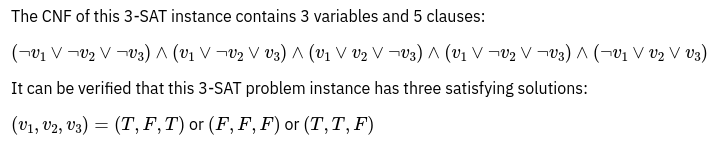

## The oracle

Here's the oracle constructed by Qiskit. An oracle is a "classical" circuit that computes the above boolean equation.

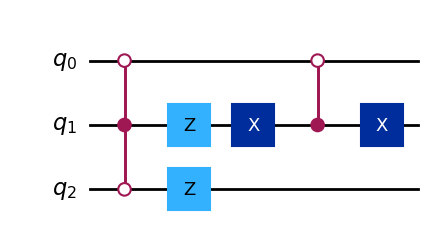

In [45]:
oracle.draw('mpl')

The above circuit is abstract: it is not adapted to the logical qubit emulator of Alice & Bob. The next cell transpiles the oracle circuit and shows how it would be executed on the logical qubit emulator.

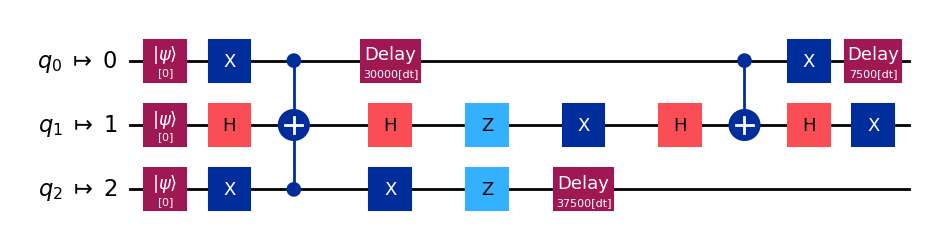

In [46]:
transpile(oracle, backend).draw('mpl')

Although the above transpilation is far from perfect (some sequence of gates could be simplified), this circuit is ready to be executed on the emulator. In particular, it only uses gates that are available on Alice & Bob's logical qubit emulator.

## Grover amplification

The oracle is seldom executed on its own: it is usually included in a larger circuit.
In the case of Grover's algorithm, the oracle is included in the so-called Grover's operator.

In a nutshell, Grover's operator will use the oracle to evaluate the SAT equation and will assign more weights to the qubit values that satisfy the SAT problem. This will make solutions more likely to be sampled than non-solutions.

In [ ]:
problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
sampler = BackendSampler(backend, options={'shots': 100_000})
grover = Grover(sampler=sampler)
result = grover.amplify(problem)

Here's the Grover's operator circuit that will be used:

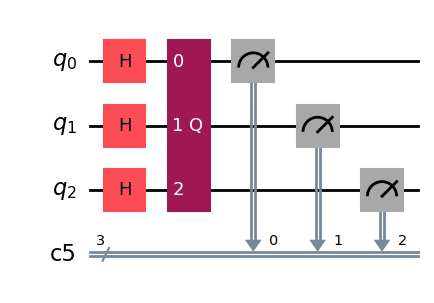

In [48]:
sampler._circuits[0].draw('mpl')

The circuit contains a sub-circuit. Let's peek inside:

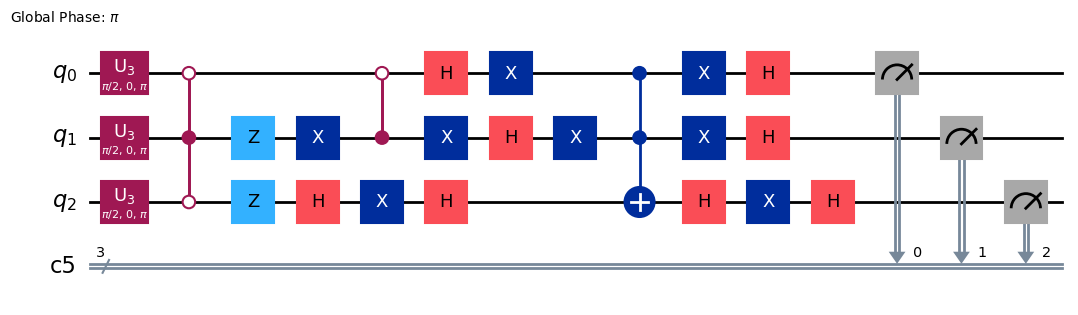

In [49]:
sampler._circuits[0].decompose(reps=2).draw('mpl')

This circuit contains gates that are not supported by Alice & Bob's logical qubits. Moreover, it is not scheduled.
Transpiling it will solve this:

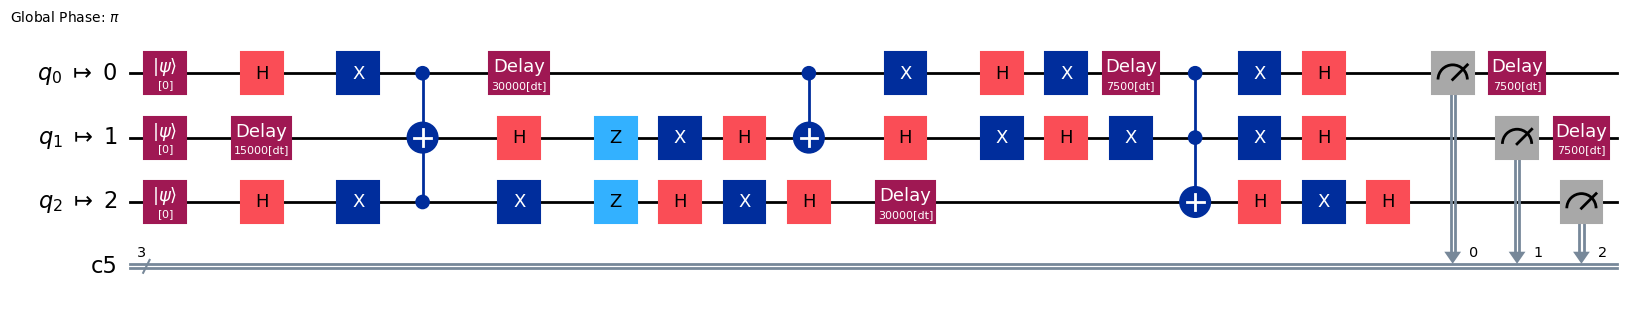

In [50]:
sampler.transpiled_circuits[0].draw('mpl')

Finally, the next cell shows the results of the circuit execution.
Note that solutions to the SAT problem (000, 011, 101) have been sampled many more times than other values.

This histogram is almost identical to the one of Qiskit tutorial from which this example is adapted. In the tutorial, the emulation was noiseless. 
How come the same results are obtained with a noisy emulator of logical qubits? That's because the `EMU:40Q_LOGICAL_TARGET` model represents logical qubits with high fidelity. The small amount of noise cannot be observed on such a small circuit.

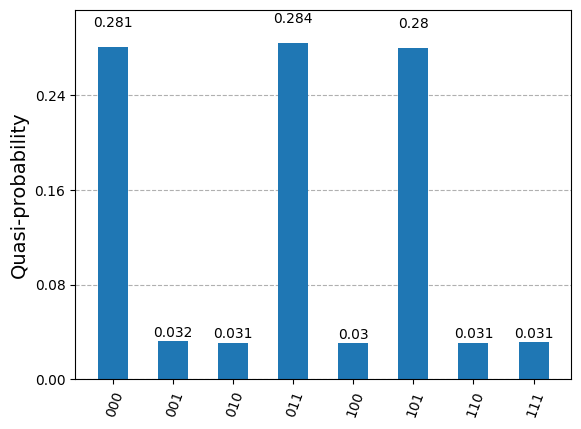

In [51]:
plot_histogram(result.circuit_results[0])

Finally, the next cell shows the results of the circuit execution.
Note that solutions to the SAT problem (000, 011, 101) have been sampled many more times than other values.

This histogram is almost identical to the one of Qiskit tutorial from which this example is adapted. In the tutorial, the emulation was noiseless. 
How come the same results are obtained with a noisy emulator of logical qubits? That's because the `EMU:40Q_LOGICAL_TARGET` model represents logical qubits with high fidelity. The small amount of noise cannot be observed on such a small circuit.

To see the impact of the logical error rate, we'll use the less optimistic `EMU:15Q:LOGICAL_EARLY` model, and tweak its parameters (error correction code distance and number of photons in the physical cat qubits memory) further to increase the logical error rate.

In [52]:
degraded_backend = provider.get_backend('EMU:15Q:LOGICAL_EARLY', average_nb_photons=4, distance=5)

In [ ]:
problem = AmplificationProblem(oracle, is_good_state=oracle.evaluate_bitstring)
sampler = BackendSampler(degraded_backend, options={'shots': 100_000})
grover = Grover(sampler=sampler)
result = grover.amplify(problem)

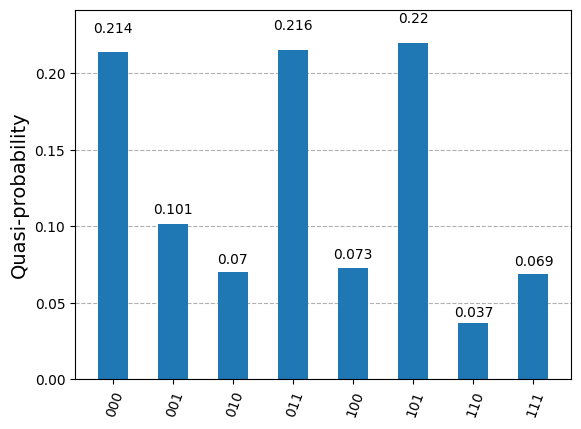

In [54]:
plot_histogram(result.circuit_results[0])

The logical errors cause the solutions to be sampled fewer times than in the almost noiseless emulation.